In [1]:
vs30img = 'vs30_mosaic.tif'
adm_kt = 'Adm_Kecamatan_Semarang.geojson'

In [2]:
import rasterio
from rasterio.plot import show
import rasterio.features
import rasterio.warp
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default='notebook+pdf'
import geopandas as gpd
from shapely.geometry import Point, Polygon

In [3]:
kota = gpd.read_file(open(adm_kt,'rb'))
points = kota[kota.type == 'Point'].geometry.reset_index(drop=True)
kota = kota[kota.type == 'Polygon']
kota['centroid'] = points
print(kota.type)
print(kota.crs)
print(kota.bounds)

0     Polygon
1     Polygon
2     Polygon
3     Polygon
4     Polygon
5     Polygon
6     Polygon
7     Polygon
8     Polygon
9     Polygon
10    Polygon
11    Polygon
12    Polygon
13    Polygon
14    Polygon
15    Polygon
dtype: object
epsg:4326
          minx      miny        maxx      maxy
0   110.438461 -7.006198  110.453840 -6.949125
1   110.401949 -7.011474  110.449563 -6.981061
2   110.386664 -7.031311  110.420465 -6.994469
3   110.415688 -7.031499  110.444827 -6.997418
4   110.430654 -6.997077  110.444116 -6.949964
5   110.393785 -6.977488  110.444924 -6.935533
6   110.401485 -6.994293  110.432021 -6.967116
7   110.363256 -7.014940  110.402527 -6.945523
8   110.441088 -6.999028  110.508884 -6.931992
9   110.449282 -7.040638  110.504978 -6.962588
10  110.287414 -6.986982  110.367386 -6.936459
11  110.339309 -7.114464  110.406935 -7.017413
12  110.428173 -7.085473  110.501101 -7.006198
13  110.267286 -7.106384  110.364622 -7.010324
14  110.397522 -7.111866  110.457273 -7.024385


In [4]:
img = rasterio.open(vs30img)
print(img.crs)
print(img.transform)
print(img.width)
print(img.height)
print(img.count)
print(img.bounds)
print(img.driver)
print(img.nodatavals)
print(img.meta)

EPSG:4326
| 0.01, 0.00, 110.24|
| 0.00,-0.01,-6.91|
| 0.00, 0.00, 1.00|
48
44
1
BoundingBox(left=110.23749999988394, bottom=-7.279166666686152, right=110.6374999998838, top=-6.912500000019634)
GTiff
(2147483647.0,)
{'driver': 'GTiff', 'dtype': 'int32', 'nodata': 2147483647.0, 'width': 48, 'height': 44, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333333330492, 0.0, 110.23749999988394,
       0.0, -0.008333333333329952, -6.912500000019634)}


In [5]:
with rasterio.open(vs30img) as dataset:

    # Read the dataset's valid data mask as a ndarray.
    mask = dataset.dataset_mask()

    # Extract feature shapes and values from the array.
    for geom, val in rasterio.features.shapes(
            mask, transform=dataset.transform):

        # Transform shapes from the dataset's own coordinate
        # reference system to CRS84 (EPSG:4326).
        geom = rasterio.warp.transform_geom(
            dataset.crs, 'EPSG:4326', geom, precision=6)

        # Print GeoJSON shapes to stdout.
        print(geom)

{'type': 'Polygon', 'coordinates': [[[110.2375, -6.9125], [110.2375, -7.279167], [110.245833, -7.279167], [110.245833, -6.9125], [110.2375, -6.9125]]]}
{'type': 'Polygon', 'coordinates': [[[110.245833, -6.9125], [110.245833, -7.279167], [110.629167, -7.279167], [110.629167, -6.9125], [110.245833, -6.9125]]]}
{'type': 'Polygon', 'coordinates': [[[110.629167, -6.9125], [110.629167, -7.279167], [110.6375, -7.279167], [110.6375, -6.9125], [110.629167, -6.9125]]]}


In [6]:
with rasterio.open(vs30img) as src:
    #read image
    image= src.read()
    # transform image
    bands,rows,cols = np.shape(image)
    image1 = image.reshape (rows*cols,bands)
    print(np.shape(image1))
    # bounding box of image
    l,b,r,t = src.bounds
    #resolution of image
    res = src.res
    res = src.res
    # meshgrid of X and Y
    x = np.arange(l,r, res[0])
    y = np.arange(t,b, -res[0])
    X,Y = np.meshgrid(x,y)
    print (np.shape(X))
    # flatten X and Y
    newX = np.array(X.flatten('C'))
    newY = np.array(Y.flatten('C'))
    print (np.shape(newX))
    # join XY and Z information
    export = np.column_stack((newX, newY, image1))
    fname='XYZ.csv'
    with open(fname, 'w') as fp:
        a = csv.writer(fp, delimiter=',')
        a.writerows(export)
        fp.close() # close file

(2112, 1)
(44, 48)
(2112,)


In [7]:
def plot(df,col):
  data = df[['lon','lat',col]].pivot(index='lat', columns='lon', values=col)
  mx = max(pd.to_numeric(df[col]))
  fig, ax = plt.subplots(1,figsize = (18, 9))
  plt.contourf(
    data.columns.values,
    data.index.values,
    data, 
    cmap = "viridis", 
  )
  cbar = plt.colorbar()
  plt.contour(
    data.columns.values,
    data.index.values,
    data, 
    cmap = "seismic",
  )
  kota.plot(edgecolor="black", facecolor="None", ax=ax, linewidth = 2)
  for x, y, label in zip(kota['centroid'].x, kota['centroid'].y, kota["name"]):
    plt.text(x, y, label, fontsize = 8, c='white', ha='center')
  plt.title(f'Peta {col}')
  plt.gca().set_aspect('equal', adjustable='box')
  plt.show()

In [8]:
adj = 0.05
kota.bounds
bbox = (min(kota.bounds.minx)-adj,max(kota.bounds.maxx)+adj,min(kota.bounds.miny)-adj,max(kota.bounds.maxy)+adj)
bbox

(110.2172863, 110.5588836, -7.164463899999999, -6.8819917)

In [9]:
imx = pd.read_csv('XYZ.csv', names=['lon','lat','VS30'])
imx = imx[imx['VS30']!=img.nodatavals[0]].reset_index(drop=True)
imx['F0'] = imx['VS30']/120
imx['Log VS30'] = np.log10(imx['VS30'])
imx['Log VS30_x'] = 2.367 - (0.852 * imx['Log VS30'])
imx['A0'] = pow(10,imx['Log VS30_x'])
imx['Kg'] = imx['A0'] ** 2 / imx['F0']  
imx = imx[(imx.lon>=bbox[0])&(imx.lon<=bbox[1])&(imx.lat>=bbox[2])&(imx.lat<=bbox[3])].reset_index(drop=True)
imx

lon     lat   VS30        F0  Log VS30  Log VS30_x        A0  \
0     110.245833 -6.9125  192.0  1.600000  2.283301    0.421627  2.640142   
1     110.254167 -6.9125  183.0  1.525000  2.262451    0.439392  2.750373   
2     110.262500 -6.9125  193.0  1.608333  2.285557    0.419705  2.628483   
3     110.270833 -6.9125  197.0  1.641667  2.294466    0.412115  2.582943   
4     110.279167 -6.9125  197.0  1.641667  2.294466    0.412115  2.582943   
...          ...     ...    ...       ...       ...         ...       ...   
1173  110.520833 -7.1625  476.0  3.966667  2.677607    0.085679  1.218089   
1174  110.529167 -7.1625  434.0  3.616667  2.637490    0.119859  1.317828   
1175  110.537500 -7.1625  422.0  3.516667  2.625312    0.130234  1.349689   
1176  110.545833 -7.1625  440.0  3.666667  2.643453    0.114778  1.302502   
1177  110.554167 -7.1625  339.0  2.825000  2.530200    0.211270  1.626559   

            Kg  
0     4.356470  
1     4.960363  
2     4.295703  
3     4.063915  
4     4.063915  
...        ...  
1173  0.374052  
1174  0.480185  
1175  0.518008  
1176  0.462685  
1177  0.936529  

[1178 rows x 8 columns]

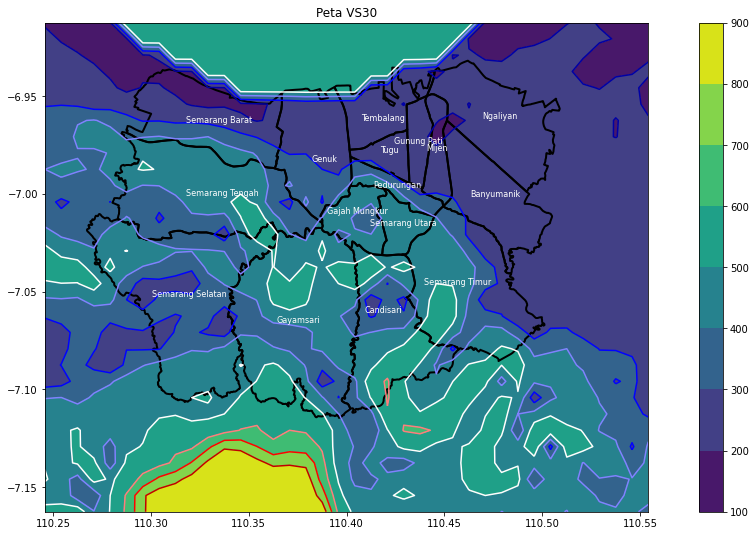

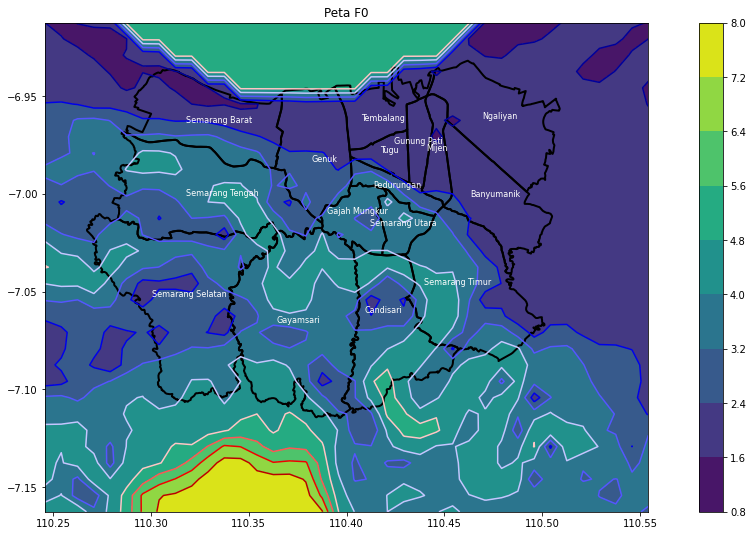

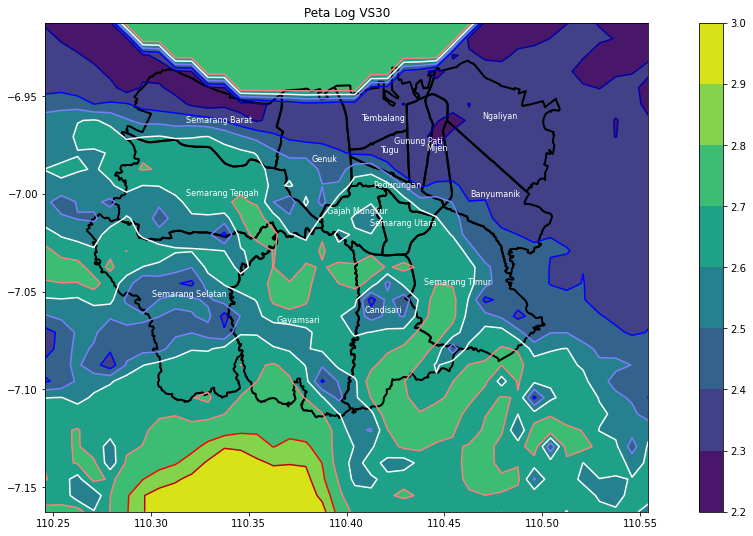

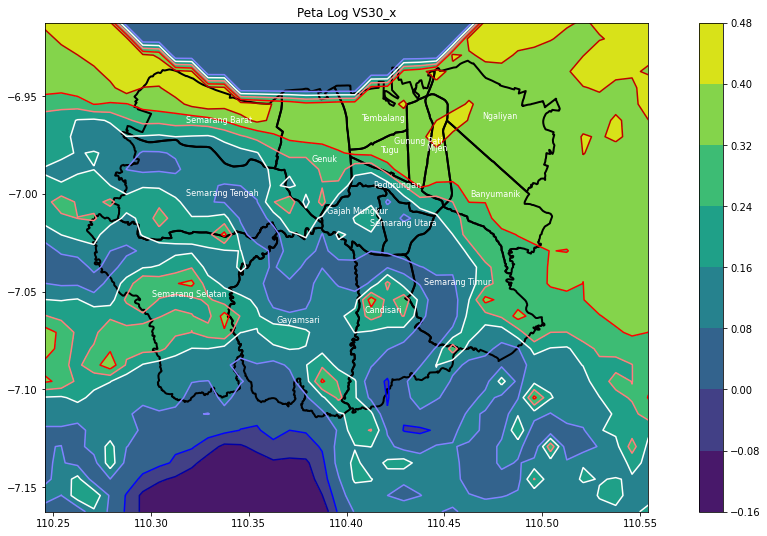

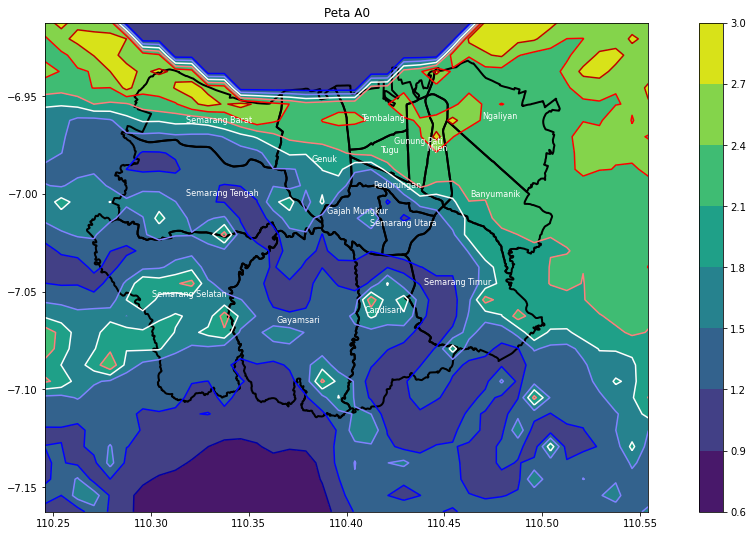

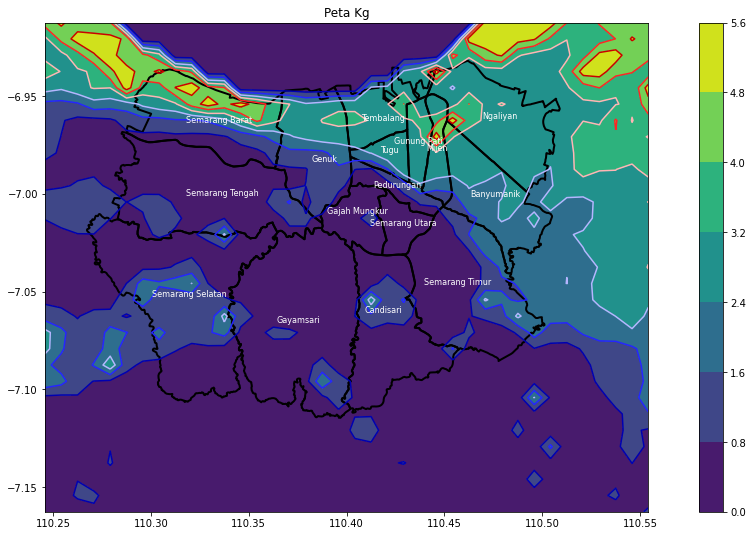

In [10]:
for n in range(2,len(imx.columns)):
  plot(imx,imx.columns[n])

In [11]:
for col in imx.columns[2:]:
  data  = imx[['lon','lat',col]].pivot(index='lat', columns='lon', values=col)
  fig = go.Figure()
  fig.add_trace(
      go.Contour(
          z = data,
          x = data.columns.values,
          y = data.index.values,
          colorscale='Viridis',
          line_smoothing=0.85,
      )
  )
  for n in range(len(kota)):
    fig.add_trace(
        go.Scatter(
          x = list(kota.geometry[n].exterior.xy[0]),
          y = list(kota.geometry[n].exterior.xy[1]),
          showlegend = False,
          line=dict(
              color="black",
              width=3,
              # dash="dashdot"
          ),
      )
    )
  fig.add_trace(
      go.Scatter(
          x=kota['centroid'].x,
          y=kota['centroid'].y,
          text=kota['name'],
          textfont=dict(
              family="sans serif bold",
              size=14,
              color="white"
          ),
          mode="text",
          showlegend = False,
      )
  )
  fig.update_layout(
      title=f'Peta {col} Semarang', 
      autosize=False,
      width=800,
      height=800,
    )
  fig.show()

In [12]:
for n in range(len(kota)):
  for i in range(len(imx)):
  # print(kota.geometry[n].contains(Point(110.390677,-7.068337)))
    if (kota.geometry[n].contains(Point(imx.lon[i],imx.lat[i]))):
  # if kota.geometry[n].contains(Point(110.390677,-7.068337)):
      print(kota.name[n])

Gayamsari
Gayamsari
Gayamsari
Gayamsari
Gayamsari
Gayamsari
Semarang Selatan
Semarang Selatan
Semarang Selatan
Semarang Selatan
Semarang Selatan
Semarang Selatan
Semarang Selatan
Semarang Selatan
Semarang Selatan
Gajah Mungkur
Gajah Mungkur
Gajah Mungkur
Gajah Mungkur
Gajah Mungkur
Gajah Mungkur
Gajah Mungkur
Gajah Mungkur
Gajah Mungkur
Gajah Mungkur
Candisari
Candisari
Candisari
Candisari
Candisari
Candisari
Candisari
Candisari
Candisari
Semarang Timur
Semarang Timur
Semarang Timur
Semarang Timur
Semarang Timur
Semarang Timur
Semarang Utara
Semarang Utara
Semarang Utara
Semarang Utara
Semarang Utara
Semarang Utara
Semarang Utara
Semarang Utara
Semarang Utara
Semarang Utara
Semarang Utara
Semarang Utara
Semarang Utara
Semarang Tengah
Semarang Tengah
Semarang Tengah
Semarang Tengah
Semarang Tengah
Semarang Tengah
Semarang Tengah
Semarang Tengah
Semarang Barat
Semarang Barat
Semarang Barat
Semarang Barat
Semarang Barat
Semarang Barat
Semarang Barat
Semarang Barat
Semarang Barat
Semarang 